During the COVID-19 outbreak in spring 2020, preventive confinement at day D for susceptible individuals was implemented in several countries to “bend” the infection curve and control the spread of the virus. Let us assume that confined individuals are effectively protected from infection. A “bending” or flattening of the (log-scale) curve representing the number of active cases was widely publicized as a sign that the epidemics was under control.

* Given a set of parameters compatible with the current knowledge about COVID-19, estimate the fraction of the susceptible population that must be put into preventive confinement to stop the spread of the virus. How does the delay D affect the effectiveness of the confinement?
* Explore parameter values that do and do not lead to virus remission. Is the bending of the active cases curve a good predictor of whether the infection will keep growing or remit?
* Study the date at which the peak of the infection is reached. How sensitive is it with respect to small changes in the parameters? Given the uncertainty of COVID-19 epidemiological parameters, what do you think about media predictions of the peak and end dates of the infection?

***

To adequately model the CoViD-19 pandemic, I will use a compartimental model approach, more concretely a SEIR model based on [a publication by Alóndiga et al](https://oa.upm.es/67410/) which was actually created by... hum! me!. In this work, we define a modified SEIR model with the following compartiments:

\begin{align*}
\frac{dS}{dt} &= -\beta\:I\:\frac{S}{N}\\
\frac{dE}{dt} &= \beta\:I\:\frac{S}{N} - \delta E\\
\frac{dI}{dt} &= \delta\:E - (1-a)\:\gamma\:I - \eta\:a\:I\\
\frac{dH}{dt} &= \eta\:(1-a)\:I-\tau\:(1-u)\:H - u\:\sigma\:H\\
\frac{dC}{dt} &= u\:\sigma\:H - m\:\rho\:min(UCI, C) - max(0, C-UCI) - \omega\:(1-m)\:min(UCI,C)\\
\frac{dR}{dt} &= \gamma\:(1-a)\:I + \tau\:(1-u)\:H + \omega\:(1-m)\:min(UCI,C)\\
\frac{dM}{dt} &= m\:\rho\:min(UCI, C) + max(0, C-UCI)\\
\end{align*}

This compartiments can be described as:

 - S: susceptible to contracting the disease
 - E: exposed to infected individuals, incubate the disease but are not yet contagious.
 - I: infected, spread the disease
 - R: have overcome the disease, do not spread the virus and have developed immunity to it. 
 - C: infected individuals requiring intensive care. 
 - M: deceased by COVID-19

(For equations in LateX and Jupyter [see here](https://stackoverflow.com/questions/29505406/ipython-notebook-wont-convert-to-pdf-when-using-align))

The meaning of all the parameters at large can be checked in the extended article, [availaible here](https://www.pablomarcos.me/files/%20Al%c3%b3ndiga_Marcos_Pat%c3%b3n_Estudio_de_la_Pandemia_por_CoViD-19_mediante_modelos_compartimentales.pdf), but, to sum up the most interesting aspects of the model:

In [1]:
import sympy as sp #as allways, we need the imports first :D
import numpy as np
import scipy.integrate as scint
import matplotlib.pyplot as plt

* The $R_{0}$ decreases progressively following a logistic curve starting with the date of aplication of the measures, A. This is to take into account natural human behaviour: people dont inmediately cessate all activity after confinement, and they dont just start taking preventive measures the day the confinement is decreted; rather, fear and necessity make for a more progressive approach:

In [2]:
def R_0(t, R_0i, R_0f, k, A):
    return (R_0i-R_0f) / (1 + np.exp(-k*(-t+A))) + R_0f

* UCI internment is accounted for with the creation of an **Hospitalizados** and a **Criticos** class, made up of the individuals that require internment and of those that require intensive care, and are thus more at risk of death. ICU occupation rates are also accounted for, and it is estimated that, due to political pressure, UCI capacity will also increase with time

In [3]:
def modelo(dias, N, UCI_100, R_0i, R_0f, k, A, u, m, a, s):
    def b(t):
        return R_0(t, R_0i, R_0f, k, A) * gamma
    
    def UCI(t):
        UCI_0 = UCI_100 / 100_000 * N  
        return UCI_0 + s*UCI_0*t 

    P0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    tiempo = np.linspace(0, dias-1, dias, dtype=int)
    Ps = scint.odeint(F, P0, tiempo, args=(N, b, m, u, a, UCI))
    S = Ps[:,0]
    E = Ps[:,1]
    I = Ps[:,2]
    H = Ps[:,3]
    C = Ps[:,4]
    R = Ps[:,5]
    M = Ps[:,6]
    R_0t = R_0(tiempo, R_0i, R_0f, k, A)

    return S, E, I, H, C, R, M, R_0t

Finally, we can tell python the equations we will use; the parameters, such as delta and rho, are extracted from relevant previous literature:

In [39]:
delta = 1/3; gamma = 1/9.0; sigma = 1/4.5
rho = 1/14; omega = 1/6.5; eta = 1/9.0
tau = 1/14; UCI_100 = 9.7 #UCI_100 = the pre-existing UCI capacity per 100.000 habitants

In [5]:
def F(P, t, N, b, m, u, a, UCI):
    S, E, I, H, C, R, M = P
    dS = -b(t) * S * I / N
    dE = b(t) * S * I / N - delta * E
    dI = delta * E - I*eta*a - I*gamma*(1-a)
    dH = eta*a*I-tau*(1-u)*H-u*sigma*H
    dC = u*sigma*H - m*rho*min(UCI(t),C) - max(0,C-UCI(t))-omega*(1-m)*min(UCI(t),C)
    dR = I*gamma*(1-a) + tau*(1-u)*H + omega*(1-m)*min(UCI(t),C)
    dM = m*rho*min(UCI(t),C) + max(0,C-UCI(t))
    return dS, dE, dI, dH, dC, dR, dM

In the paper, the authors fit the model to actual, real, pre-existing data, and come up with the following values, with 2 exceptions: population is the Spainish population in the 2020 census, according to Wikipedia, and "dias" is the number of days we are studying; in this case, 184

In [6]:
R_0i = 4.244; R_0f= 0.848; u = 0.150
k = 5.392; m = 0.199; a = 0.125
s = 0.012; population = 47450795; dias = 184

And that's it! With this, we can define the plot function that we will use to analyse the behaviour of covid (and of our model!)

In [31]:
def plotseircm(A):
    mod = modelo(dias, population, UCI_100, R_0i, R_0f, k, A, u, m, a, s)
    tiempo = np.linspace(0,dias)
    susceptibles = mod[0]
    exposeados = mod[1]
    infectados = mod[2]
    hospitalizados = mod[3]
    criticos = mod[4]
    recuperados = mod[5]
    muertos= mod[6]
    R_0t = mod[7]
    muertes_diarias=[0]
    for i in range(0, len(muertos)-1):
        muertes_diarias.append(muertos[i+1]-muertos[i])

    plt.plot(range(dias), exposeados, "-", label = "Exposed", color ='#ff7f0e')
    plt.plot(range(dias), infectados, "-", label = "Infected", color = '#2ca02c')
    plt.plot(range(dias), hospitalizados, "-", label = "Hospitalized", color = '#e377c2' )
    plt.plot(range(dias), criticos, label = "Critical", color = '#d62728')
    plt.plot(range(dias), muertos, "-", label = "Muertos", color = 'black')
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.xticks(rotation=40)
    plt.legend()
    plt.subplots_adjust(bottom=0.2, top=1.3) #So that plots look cute
    plt.ticklabel_format(style='plain', axis = 'y')
    
    #Guardamos como pinta el panorama
    panorama=[muertos[123],susceptibles[123], exposeados[123],infectados[123],hospitalizados[123], criticos[123],recuperados[123]]
    return panorama

We define a dataframe to store the raw, numeric values we will later use to compare, and we plot the graphs:

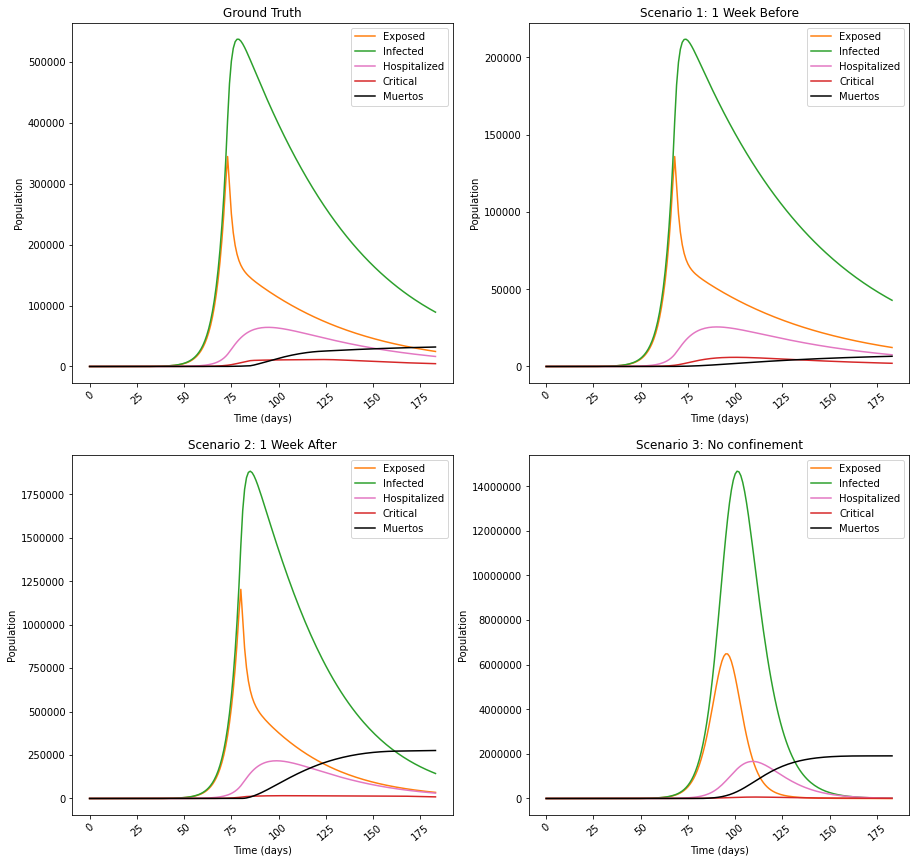

In [34]:
totals = []
plt.subplots(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title('Ground Truth')
totals.append(plotseircm(73))
plt.subplot(2, 2, 2)
plt.title('Scenario 1: 1 Week Before')
totals.append(plotseircm(68))
plt.subplot(2, 2, 3)
plt.title('Scenario 2: 1 Week After')
totals.append(plotseircm(80))
plt.subplot(2, 2, 4)
plt.title('Scenario 3: No confinement')
totals.append(plotseircm(100000)) #Out of scope, effectively no confinement
plt.show()

In [13]:
import pandas as pd
df = pd.DataFrame(columns=['Dead','Susceptible','Exposed','Infected','Hospitalized',
                      'Critical','Recovered'], data=totals)
pd.set_option('display.float_format', lambda x: '%.f' % x)
df

,Dead,Susceptible,Exposed,Infected,Hospitalized,Critical,Recovered
0,25085,44592488,75403,268567,47499,11390,2430362
1,3747,46234518,30963,107323,18580,4946,1050718
2,201714,38982780,203888,804348,154462,15043,7088558
3,1262664,6799399,149374,2571360,895854,41298,35730846


As we can see, there is quite a big difference between the 4 scenarios, so, yes, ¡confinement is useful! Also in the table above, we can see that, the bigger the delay 'D', the more ineffective the confinement is, as the epidemic has had more time to progress; had the Spanish government decreed confinement a week earlier, more than 20000 lives could have been spared.

Now, given the known parameters for the model (provided in cell [4]), we can calculate the fraction of the 
susceptible population that must be put into preventive confinement to stop the spread of the virus. [According to PNAS](https://www.pnas.org/content/pnas/118/21/e2107692118.full.pdf), mathematically, "the herd immunity threshold can be very simply calculated as $\omega = 1 - \frac{1}{R_{0}}$". If we take the model's predicted $R_{0}i$ (that is, the one that corresponds to free virus circulation) of 4.244, we get an $\omega$ of $1 - \frac{1}{4.244}$ = 0.7643, that is, 76.43 percent of the population that needs to be virus-proof for the epidemic to cessate. If we discount the percentage of infected population, I, from that percentage, we get the fraction of individuals that must be confined to stop the disease from spreading. 

Given that the Infected population is constantly changing, as is $R_{0}$ according to our model, this proportion might be better defined by creating a function.

Now, lets explore some different parameter values and see wether they lead to virus remision or not. I will play with $\delta$, $\gamma$ and $\eta$, the original pàrameters in the SEIR model; $\beta$ cannot be modified since it is set to dynamically change with time (our way of affecting $R_{0}(t)$).Thus:

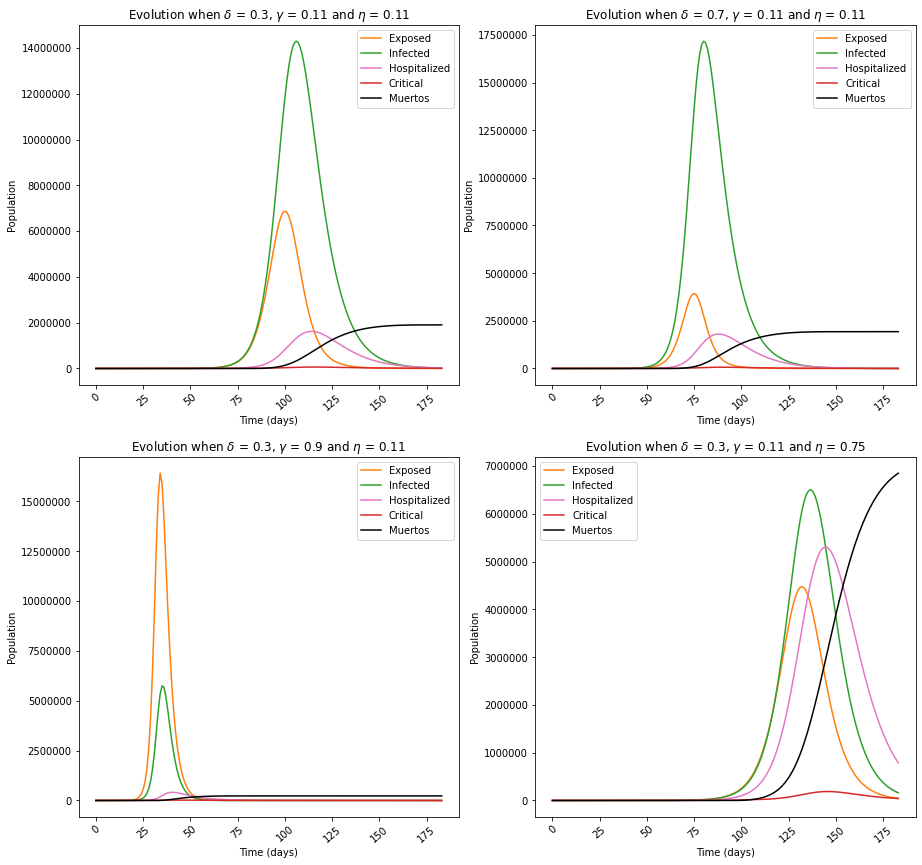

In [58]:
plt.subplots(figsize=(15, 10))
plt.subplot(2, 2, 1)
delta = 0.3; gamma = 0.11; eta = 0.11
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.subplot(2, 2, 2)
delta = 0.7; gamma = 0.11; eta = 0.11
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.subplot(2, 2, 3)
delta = 0.3; gamma = 0.9; eta = 0.11
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.subplot(2, 2, 4)
delta = 0.3; gamma = 0.11; eta = 0.75
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.show()

As was predictable, each one of the parameters does what it was assigned to do: $\delta$ is the rate at which individuals incubating the virus develop symptoms and become infectious, so increasing it leads to a huge spike in the Infected department (although,in reality, it may lead to a decrease: the big problem with CoViD are asymptomatic patients). $\gamma$ is the inverse of the period of recuperation: if we increase it, the Exposed department increases, as, when individuals take more to recover, they can infect more people; finally, $\eta$, the inverse of the period of symptom development: if it increases, the number of infected patients decrease, while the hospitalizations increase, as do, in turn, deaths. Exposed, however, remains constant: it seems like the infection has become more lethal.

With regards to the bending of the curve, common sense, as well as the analysis on Exercise 2.1, seem to indicate that, while the bending is not a predictor of wether the infection will **end** or not, it is, in fact, a good predictor of its evolution (it is, after all, a growth curve), so it does help decide wether the infection will keep growing or remit for the time being, helping the system cope.

Finally, we can study the peak of the infection and its sensibility to small changes in the parametes:

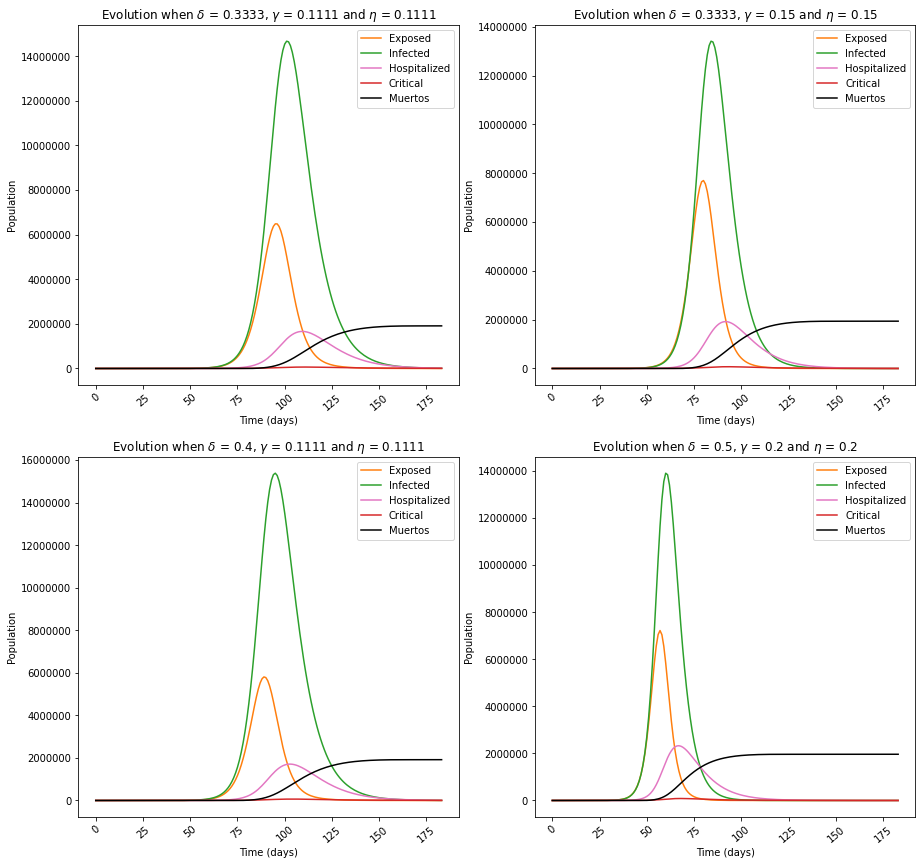

In [59]:
plt.subplots(figsize=(15, 10))
plt.subplot(2, 2, 1)
delta = 0.3333; gamma = 0.1111; eta = 0.1111
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.subplot(2, 2, 2)
delta = 0.3333; gamma = 0.15; eta = 0.15
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.subplot(2, 2, 3)
delta = 0.4; gamma = 0.1111; eta = 0.1111
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.subplot(2, 2, 4)
delta = 0.5; gamma = 0.2; eta = 0.2
plt.title('Evolution when $\delta$ = {0}, $\gamma$ = {1} and $\eta$ = {2}'.format(str(delta), str(gamma), str(eta)))
plotseircm(1000);
plt.show()

As can be seen, the impact of really, really small changes in the parameter's value is neglegible, but, when we do a somewhat bigger modification9, the thing changes: the prediction is off by more than 20 days. Given that accurate models can become more and more complex, whith an increased number of parameters and equations, small changes in said parameters can widely change the "peak date" prediction. In general, it can be said that it is difficult to predict things in the field of mathematical biology, and that models in general do have some degree of uncertainty; however, even though media predictions were in fact bad, they were the best we had, and thus modelling remains an important and useful field to manage pandemics. 